# 1. Import Packages for the Environment

In [1026]:
# Import basic packages for later use
import os
import shutil
from collections import OrderedDict

import json
import matplotlib.pyplot as plt
import nibabel as nib

import numpy as np
import torch

In [1027]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [1028]:
IN_KAGGLE = os.path.exists('/kaggle/input')
IN_COLAB = not IN_KAGGLE and os.path.exists('/content')
IN_DEIB = os.path.exists('/workspace')
IN_LOCAL = not IN_KAGGLE and not IN_COLAB and not IN_DEIB

In [1029]:
if IN_KAGGLE or IN_COLAB:
    !pip install nnunetv2
    !pip install captum

# 2. Mount the dataset

In [1030]:
if IN_COLAB:
    # Google Colab
    # for colab users only - mounting the drive

    from google.colab import drive
    drive.mount('/content/drive',force_remount = True)

    drive_dir = "/content/drive/My Drive"
    mount_dir = drive_dir + "/tesi/automi"
    base_dir = os.getcwd()
elif IN_KAGGLE:
    # Kaggle
    mount_dir = "/kaggle/input/automi-seg"
    base_dir = os.getcwd()
    print(base_dir)
    !ls '/kaggle/input'
    !cd "/kaggle/input/automi-seg" ; ls
elif IN_DEIB:
    mount_dir = "/workspace/data"
    base_dir = "/workspace/output"
    os.chdir(base_dir)
    print("base_dir:", base_dir)
else:
    # Local
    mount_dir = "/Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/data"
    base_dir = "/Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output"
    os.chdir(base_dir)
    print("base_dir:", base_dir)

base_dir: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output


# 3. Setting up nnU-Nets folder structure and environment variables
nnUnet expects a certain folder structure and environment variables.

Roughly they tell nnUnet:
1. Where to look for stuff
2. Where to put stuff

For more information about this please check: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/setting_up_paths.md

## 3.1 Set environment Variables and creating folders

In [1031]:
def join(*args):
    return os.path.join(*args)

In [1032]:
# ===========================
# 📦 SETUP nnUNet ENVIRONMENT
# ===========================

# Definisci i path da settare
path_dict = {
    "nnUNet_raw": join(mount_dir, "nnunet_raw"),
    "nnUNet_preprocessed": join(mount_dir, "preprocessed_files"),#"nnUNet_preprocessed"),
    "nnUNet_results": join(mount_dir, "results"),#"nnUNet_results"),
    # "RAW_DATA_PATH": join(mount_dir, "RawData"),  # Facoltativo, se ti serve salvare zips
}

# Scrivi i path nelle variabili di ambiente, che vengono lette dal modulo paths di nnunetv2
for env_var, path in path_dict.items():
    os.environ[env_var] = path

if IN_KAGGLE:
    if nnUNet_raw == None:
        nnUNet_raw = "/kaggle/input/nnunet_raw"
    if nnUNet_results == None:
        nnUNet_results = "/kaggle/input/results"
    # Kaggle has some very unconsistent behaviors in dataset mounting...
    #nnUNet_raw = "/kaggle/input/automi-seg/nnunet_raw"
    #nnUNet_results = "/kaggle/input/automi-seg/results"

if IN_LOCAL:
    nnUNet_raw = "/Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/data/Dataset003_AUTOMI_CTVLNF_NEWGL_raw_data"
    nnUNet_results = "/Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/data/Dataset003_AUTOMI_CTVLNF_NEWGL_results"
    shap_results = base_dir
    
print("nnUNet_raw:", nnUNet_raw)
print("nnUNet_results:", nnUNet_results)

nnUNet_raw: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/data/Dataset003_AUTOMI_CTVLNF_NEWGL_raw_data
nnUNet_results: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/data/Dataset003_AUTOMI_CTVLNF_NEWGL_results


### Some tests

In [1033]:
# all volumes of fold 0 test set
volume_codes = ["00004", "00005", "00024", "00027", "00029", "00034", "00039", "00044"]

In [1034]:
ct_img_paths = {}
segmentation_paths = {}
organ_map_paths = {}

for volume_code in volume_codes:
    if IN_KAGGLE:
        ct_img_paths[volume_code] = join(nnUNet_raw, "imagesTr", f"AUTOMI_{volume_code}_0000.nii")
        organ_map_paths[volume_code] = join(nnUNet_raw, "total_segmentator_structures", f"AUTOMI_{volume_code}_0000", "mask_mask_add_input_20_total_segmentator.nii")
    else:
        ct_img_paths[volume_code] = join(nnUNet_raw, "imagesTr", f"AUTOMI_{volume_code}_0000.nii.gz")
        segmentation_paths[volume_code] = join(nnUNet_results, "nnUNetTrainer__nnUNetPlans__3d_fullres", "fold_0", "test_pred", f"AUTOMI_{volume_code}.nii.gz")
        organ_map_paths[volume_code] = join(nnUNet_raw, "total_segmentator_structures", f"AUTOMI_{volume_code}_0000", "mask_mask_add_input_20_total_segmentator.nii.gz")
    ct_img = nib.load(ct_img_paths[volume_code])
    organ_map = nib.load(organ_map_paths[volume_code])
    print(f"Volume {volume_code}:")
    print("CT shape:", ct_img.shape)
    print("Organ shape:", organ_map.shape)
    print("Spacing:", ct_img.header.get_zooms())
    print("Organ spacing:", organ_map.header.get_zooms())
    assert np.all(ct_img.affine == organ_map.affine), "CT and organ mask affine matrices do not match!"

Volume 00004:
CT shape: (512, 512, 221)
Organ shape: (512, 512, 221)
Spacing: (np.float32(1.3671875), np.float32(1.3671875), np.float32(5.0))
Organ spacing: (np.float32(1.3671875), np.float32(1.3671875), np.float32(5.0))
Volume 00005:
CT shape: (512, 512, 219)
Organ shape: (512, 512, 219)
Spacing: (np.float32(1.171875), np.float32(1.171875), np.float32(5.0))
Organ spacing: (np.float32(1.171875), np.float32(1.171875), np.float32(5.0))
Volume 00024:
CT shape: (512, 512, 321)
Organ shape: (512, 512, 321)
Spacing: (np.float32(0.976562), np.float32(0.976562), np.float32(3.0))
Organ spacing: (np.float32(0.976562), np.float32(0.976562), np.float32(3.0))
Volume 00027:
CT shape: (512, 512, 236)
Organ shape: (512, 512, 236)
Spacing: (np.float32(1.3671875), np.float32(1.3671875), np.float32(5.0))
Organ spacing: (np.float32(1.3671875), np.float32(1.3671875), np.float32(5.0))
Volume 00029:
CT shape: (512, 512, 259)
Organ shape: (512, 512, 259)
Spacing: (np.float32(1.367188), np.float32(1.367188), n

### add map paths for each type

In [1035]:
SUPERVOXEL_LABELS = {
    "FCC": "Regular",
    "full-organs": "Full organs",
    "FCC-organs": "Hybrid"
}
AGGREGATION_FUNCTIONS = {
    "true_positive_aggregation": "True Positive",
    "false_positive_aggregation": "False Positive",
    "dice_aggregation": "Dice",
    "logit_difference_aggregation": "Soft Dice"
}

In [1036]:
count = 0
map_paths = {}
for sv_type in SUPERVOXEL_LABELS.keys():
    for agg_func in AGGREGATION_FUNCTIONS.keys():
        for volume_code in volume_codes:
            suffix = "_signed" if agg_func == "false_positive_aggregation" else ""
            map_dir = join(shap_results, sv_type, agg_func, volume_code, f"attribution_map{suffix}.nii.gz")
            if not os.path.exists(map_dir):
                raise ValueError(f"Map dir does not exist: {map_dir}")
            print(f"Map dir for {sv_type} - {agg_func} - {volume_code}: {map_dir}")
            map_paths[(sv_type, agg_func, volume_code)] = map_dir
            count += 1
print(f"Total maps found: {count}")

Map dir for FCC - true_positive_aggregation - 00004: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00004/attribution_map.nii.gz
Map dir for FCC - true_positive_aggregation - 00005: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00005/attribution_map.nii.gz
Map dir for FCC - true_positive_aggregation - 00024: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00024/attribution_map.nii.gz
Map dir for FCC - true_positive_aggregation - 00027: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00027/attribution_map.nii.gz
Map dir for FCC - true_positive_aggregation - 00029: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00029/attribution_map.nii.gz
Map dir for FCC - true_positive_aggregation - 00034: /Users/giulio/Desktop/tesi/ssh/XAI-AUTOMI-seg/output/FCC/true_positive_aggregation/00034/attribution_map.nii.gz
Map dir fo

### ROI maps paths

In [1037]:
ROI_TYPE = "BoundingBox"

In [1038]:
BB_ROI_paths = {}
count = 0
for volume_code in volume_codes:
    if IN_KAGGLE:
        path = f"{mount_dir}/BB-ROI/AUTOMI_{volume_code}.json"
        assert os.path.exists(path), f"BB-ROI path does not exist: {path}"
        BB_ROI_paths[volume_code] = path
    else:
        path = f"{nnUNet_results}/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/BB-ROI/AUTOMI_{volume_code}.json"
        assert os.path.exists(path), f"BB-ROI path does not exist: {path}"
        BB_ROI_paths[volume_code] = path
    count += 1
print(f"Total BB-ROI paths found: {count}")

Total BB-ROI paths found: 8


In [1039]:
import json
from pathlib import Path
from typing import Tuple, Optional
import nibabel as nib

def get_slices_from_BB_ROI(BB_ROI: dict) -> Tuple[slice, slice, slice]:
    """
    Extracts the bounding box slices from the BB_ROI dictionary.
    Parameters
    ----------
    BB_ROI : dict
        Dictionary containing the bounding box coordinates with keys:
        example:
        {'FileFormat': array('MITK ROI', dtype='<U8'), 'Version': array(2), 'Geometry': array({'Size': [512.0, 512.0, 221.0], 'Transform': [1.3671875, -0.0, -0.0, 0, -0.0, 1.3671875, -0.0, 0, 0.0, 0.0, 5.0, 0, -350.0, -278.6000061035156, -432.239990234375, 1]},
      dtype=object), 'ROIs': array([{'ID': 0, 'Max': [370.5, 291.5, 114.5], 'Min': [276.5, 193.49999999999994, 92.5], 'Properties': {'ColorProperty': {'color': [1.0, 0.0, 0.0]}, 'StringProperty': {'name': 'AUTOMI_00004_0000 Bounding Box'}}}],
      dtype=object)}
    """
    # take the ceil of both min and max (ROI in MITK apprently is shifted by 0.5 voxels)
    x_slice = slice(int(np.ceil(BB_ROI['ROIs'][0]['Min'][0])), int(np.ceil(BB_ROI['ROIs'][0]['Max'][0])))
    y_slice = slice(int(np.ceil(BB_ROI['ROIs'][0]['Min'][1])), int(np.ceil(BB_ROI['ROIs'][0]['Max'][1])))
    z_slice = slice(int(np.ceil(BB_ROI['ROIs'][0]['Min'][2])), int(np.ceil(BB_ROI['ROIs'][0]['Max'][2])))
    return x_slice, y_slice, z_slice

def load_roi_slices(
    ROI_BB_path: Optional[str] = None
) -> Tuple[slice, slice, slice]:
    """
    Load ROI definition and return bounding-box slices in x, y, z order.

    Parameters
    ----------
    ROI_BB_path : str, optional
        Path to JSON file defining the bounding box ROI.

    Returns
    -------
    x_slice, y_slice, z_slice : slice
        Slices along each axis for cropping operations.
    """

    if ROI_BB_path is None:
        raise ValueError("ROI_BB_path must be provided when ROI_type is 'BoundingBox'.")
    BB_ROI = json.load(open(ROI_BB_path, "r"))
    x_slice, y_slice, z_slice = get_slices_from_BB_ROI(BB_ROI)


    return x_slice, y_slice, z_slice


# 4. Visualization Utilities

We introduce functions to generate 1–3 anatomical plane views (axial, sagittal, coronal) for a given (supervoxel_type, aggregation_function, volume_code) triplet with layered overlays:

Layers (bottom → top):
1. CT slice (with optional intensity window / percentile normalization)
2. Attribution map slice (diverging colormap, configurable, transparency)
3. ROI bounding box outline (projected on each plane as a red rectangle)

Key design points:
- Memory efficient: only load one volume + attribution map at a time, slice lazily with nibabel dataobj.
- ROI middle slice per axis: center index = (slice.start + slice.stop)//2 for each axis.
- Flexible axis selection: parameter `axes=("axial","sagittal","coronal")`.
- Colormap configurability: diverging cmap with `TwoSlopeNorm` centered at 0; user can override, or provide explicit (vmin, vmax, center).
- Saving: optional `output_path`; figure returned regardless.
- Batch helper to iterate over multiple configurations.

Next cell defines function stubs (to be completed in following steps).

In [1043]:
def plot_supervoxel_comparison(volume_code, agg_func, map_paths, ct_img_paths, BB_ROI_paths, segmentation_paths, axes_views=("axial", "sagittal", "coronal"), **kwargs):
    sv_types = list(SUPERVOXEL_LABELS.keys())
    # Add an extra row for the CT + segmentation view
    fig, axs = plt.subplots(len(sv_types) + 1, len(axes_views), figsize=(5 * len(axes_views), 5 * (len(sv_types) + 1)), constrained_layout=True)

    # --- First row: CT + Segmentation Only ---
    ct_path = ct_img_paths[volume_code]
    roi_json_path = BB_ROI_paths[volume_code]
    segmentation_path = segmentation_paths.get(volume_code)
    
    # Use the first supervoxel type's attribution map to determine the layout, ensuring alignment
    first_sv_type = sv_types[0]
    first_attr_path = map_paths.get((first_sv_type, agg_func, volume_code))

    plot_attribution_views(
        ct_path,
        attribution_path=first_attr_path, # Used for layout calculation only
        roi_json_path=roi_json_path,
        segmentation_path=segmentation_path,
        axes_views=axes_views,
        fig_axs=(fig, axs[0, :]),
        show_colorbar=False,
        attribution_alpha=0,
        show_plane_titles=True, # Show titles for the first row
        **kwargs
    )
    axs[0, 0].text(-0.1, 0.5, "CT + Seg", ha='right', va='center', transform=axs[0, 0].transAxes, fontsize=14, rotation=90)


    # --- Subsequent rows: Supervoxel Comparisons ---
    im_for_cbar = None
    for i, sv_type in enumerate(sv_types):
        row_idx = i + 1
        row_axs = axs[row_idx, :]
        
        attribution_path = map_paths.get((sv_type, agg_func, volume_code))
        if not attribution_path:
            print(f"Skipping {sv_type} - attribution path not found.")
            for ax in row_axs: ax.set_visible(False) # Hide row if no map
            continue

        im = plot_attribution_views(
            ct_path, attribution_path, roi_json_path,
            segmentation_path=None,  # Do not show segmentation on attribution maps
            axes_views=axes_views,
            fig_axs=(fig, row_axs),
            show_plane_titles=False, # Hide titles for subsequent rows
            **kwargs
        )
        if im is not None:
            im_for_cbar = im
        
        row_axs[0].text(-0.1, 0.5, SUPERVOXEL_LABELS[sv_type], ha='right', va='center', transform=row_axs[0].transAxes, fontsize=14, rotation=90)

    if 'title' in kwargs:
        fig.suptitle(kwargs['title'], fontsize=16)
    
    if im_for_cbar and kwargs.get('show_colorbar', True):
        cbar = fig.colorbar(im_for_cbar, ax=axs.ravel().tolist(), fraction=0.022, pad=0.01)
        cbar.set_label('Attribution')
        if agg_func != 'dice_aggregation':
            formatter = mticker.ScalarFormatter(useMathText=True)
            formatter.set_powerlimits((-2, 2))
            cbar.ax.yaxis.set_major_formatter(formatter)

    return fig

def plot_aggregation_comparison(volume_code, sv_type, map_paths, ct_img_paths, BB_ROI_paths, segmentation_paths, axes_views=("axial", "sagittal", "coronal"), **kwargs):
    agg_funcs = list(AGGREGATION_FUNCTIONS.keys())
    n_rows = len(agg_funcs) + 1
    n_cols = len(axes_views)
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4.5 * n_rows))
    
    # Adjust subplot parameters for tighter padding
    fig.subplots_adjust(wspace=0.05, hspace=0.1, top=0.95, bottom=0.05, left=0.1, right=0.85)

    # --- First row: CT + Segmentation Only ---
    ct_path = ct_img_paths[volume_code]
    roi_json_path = BB_ROI_paths[volume_code]
    segmentation_path = segmentation_paths.get(volume_code)
    first_agg_func = agg_funcs[0]
    first_attr_path = map_paths.get((sv_type, first_agg_func, volume_code))

    plot_attribution_views(
        ct_path,
        attribution_path=first_attr_path,
        roi_json_path=roi_json_path,
        segmentation_path=segmentation_path,
        axes_views=axes_views,
        fig_axs=(fig, axs[0, :]),
        show_colorbar=False,
        attribution_alpha=0,
        show_plane_titles=True,
        **kwargs
    )
    axs[0, 0].text(-0.15, 0.5, "CT + Seg", ha='right', va='center', transform=axs[0, 0].transAxes, fontsize=14, rotation=90)

    # --- Subsequent rows: Aggregation Comparisons ---
    for i, agg_func in enumerate(agg_funcs):
        row_idx = i + 1
        row_axs = axs[row_idx, :]
        
        attribution_path = map_paths.get((sv_type, agg_func, volume_code))
        if not attribution_path:
            print(f"Skipping {agg_func} - attribution path not found.")
            for ax in row_axs: ax.set_visible(False)
            continue

        # Position the colorbar axis relative to the plot axes
        pos = row_axs[-1].get_position()
        cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])

        im = plot_attribution_views(
            ct_path, attribution_path, roi_json_path,
            segmentation_path=None, # Do not show segmentation on attribution maps
            axes_views=axes_views,
            fig_axs=(fig, row_axs),
            show_plane_titles=False,
            show_colorbar=True,
            cbar_ax=cbar_ax,
            **kwargs
        )
        
        if im:
            cbar = fig.colorbar(im, cax=cbar_ax)
            cbar.set_label('Attribution')
            if agg_func != 'dice_aggregation':
                formatter = mticker.ScalarFormatter(useMathText=True)
                formatter.set_powerlimits((-2, 2))
                cbar.ax.yaxis.set_major_formatter(formatter)

        row_axs[0].text(-0.15, 0.5, AGGREGATION_FUNCTIONS[agg_func], ha='right', va='center', transform=row_axs[0].transAxes, fontsize=14, rotation=90)

    if 'title' in kwargs:
        fig.suptitle(kwargs['title'], fontsize=16, y=0.99)

    return fig

### 4.1 Example Usage
Below we demonstrate generating a figure for one configuration and (optionally) a batch.
(You can comment/uncomment depending on availability of paths.)

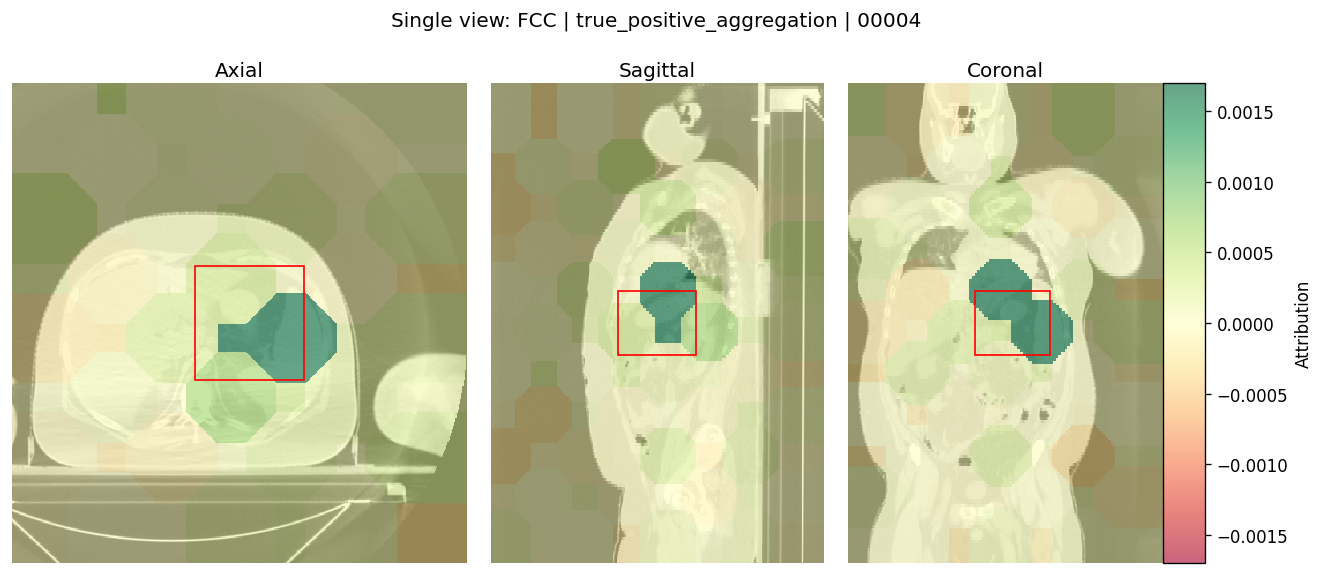

In [1041]:
# Re-run comparison for orientation fix
# Example of a single plot
sv_type_ex, agg_func_ex, volume_code_ex = 'FCC', 'true_positive_aggregation', '00004'
ct_path = ct_img_paths[volume_code_ex]
attribution_path = map_paths[(sv_type_ex, agg_func_ex, volume_code_ex)]
roi_json_path = BB_ROI_paths[volume_code_ex]

fig_single = plot_attribution_views(
    ct_path, attribution_path, roi_json_path,
    title=f"Single view: {sv_type_ex} | {agg_func_ex} | {volume_code_ex}"
)


### 4.2 Notes, Assumptions & Edge Cases

Assumptions:
- CT, attribution map, and ROI JSON share the same voxel space (verified earlier by affine checks for CT vs organ maps; attribution assumed aligned by generation process).
- Attribution map may be sparse or partially zero outside region of interest; zeros are still plotted but produce minimal color.

Edge Cases & Handling:
- If attribution slice is entirely zero, no colorbar will be shown (im_for_cbar remains None).
- If provided vmin/vmax don't straddle the center, center is recentered (TwoSlopeNorm requires ordering).
- Percentile normalization for CT can be overridden by explicit window.
- ROI rectangle uses raw voxel indices; if any orientation changes are desired (e.g., radiological vs neurological), additional flips may be needed.
- Lazy slicing relies on nibabel proxy; if an image is memory-mapped compressed and performance is slow, consider pre-fetching only needed slices.

Next Potential Improvements:
- Option to overlay organ segmentation contour.
- Alpha modulation by magnitude of attribution.
- Interactive widget to scroll along axes.
- Automatic figure grid for multiple volume codes in one canvas.
- Export to ITK-SNAP or MITK screenshot automation.

This completes the initial visualization utility implementation.

#### 4.3 Spacing Handling Addendum
The plotting functions (`plot_attribution_views`, `plot_attribution_batch`) now live directly with the helper utilities above as single authoritative definitions. With `use_physical_spacing=True` (default), each plane uses an `extent` scaled by voxel spacing `(sx, sy, sz)` from the NIfTI header, so rectangles and aspect reflect physical millimeters.

Plane extents (origin at 0,0):
- Axial (z fixed): width = X * sx, height = Y * sy
- Sagittal (x fixed): width = Y * sy, height = Z * sz
- Coronal (y fixed): width = X * sx, height = Z * sz

Bounding box rectangles are scaled consistently. If orientation flips (radiological vs neurological) are desired, apply `np.flip` to slices before normalization and adjust rectangle coordinates accordingly.

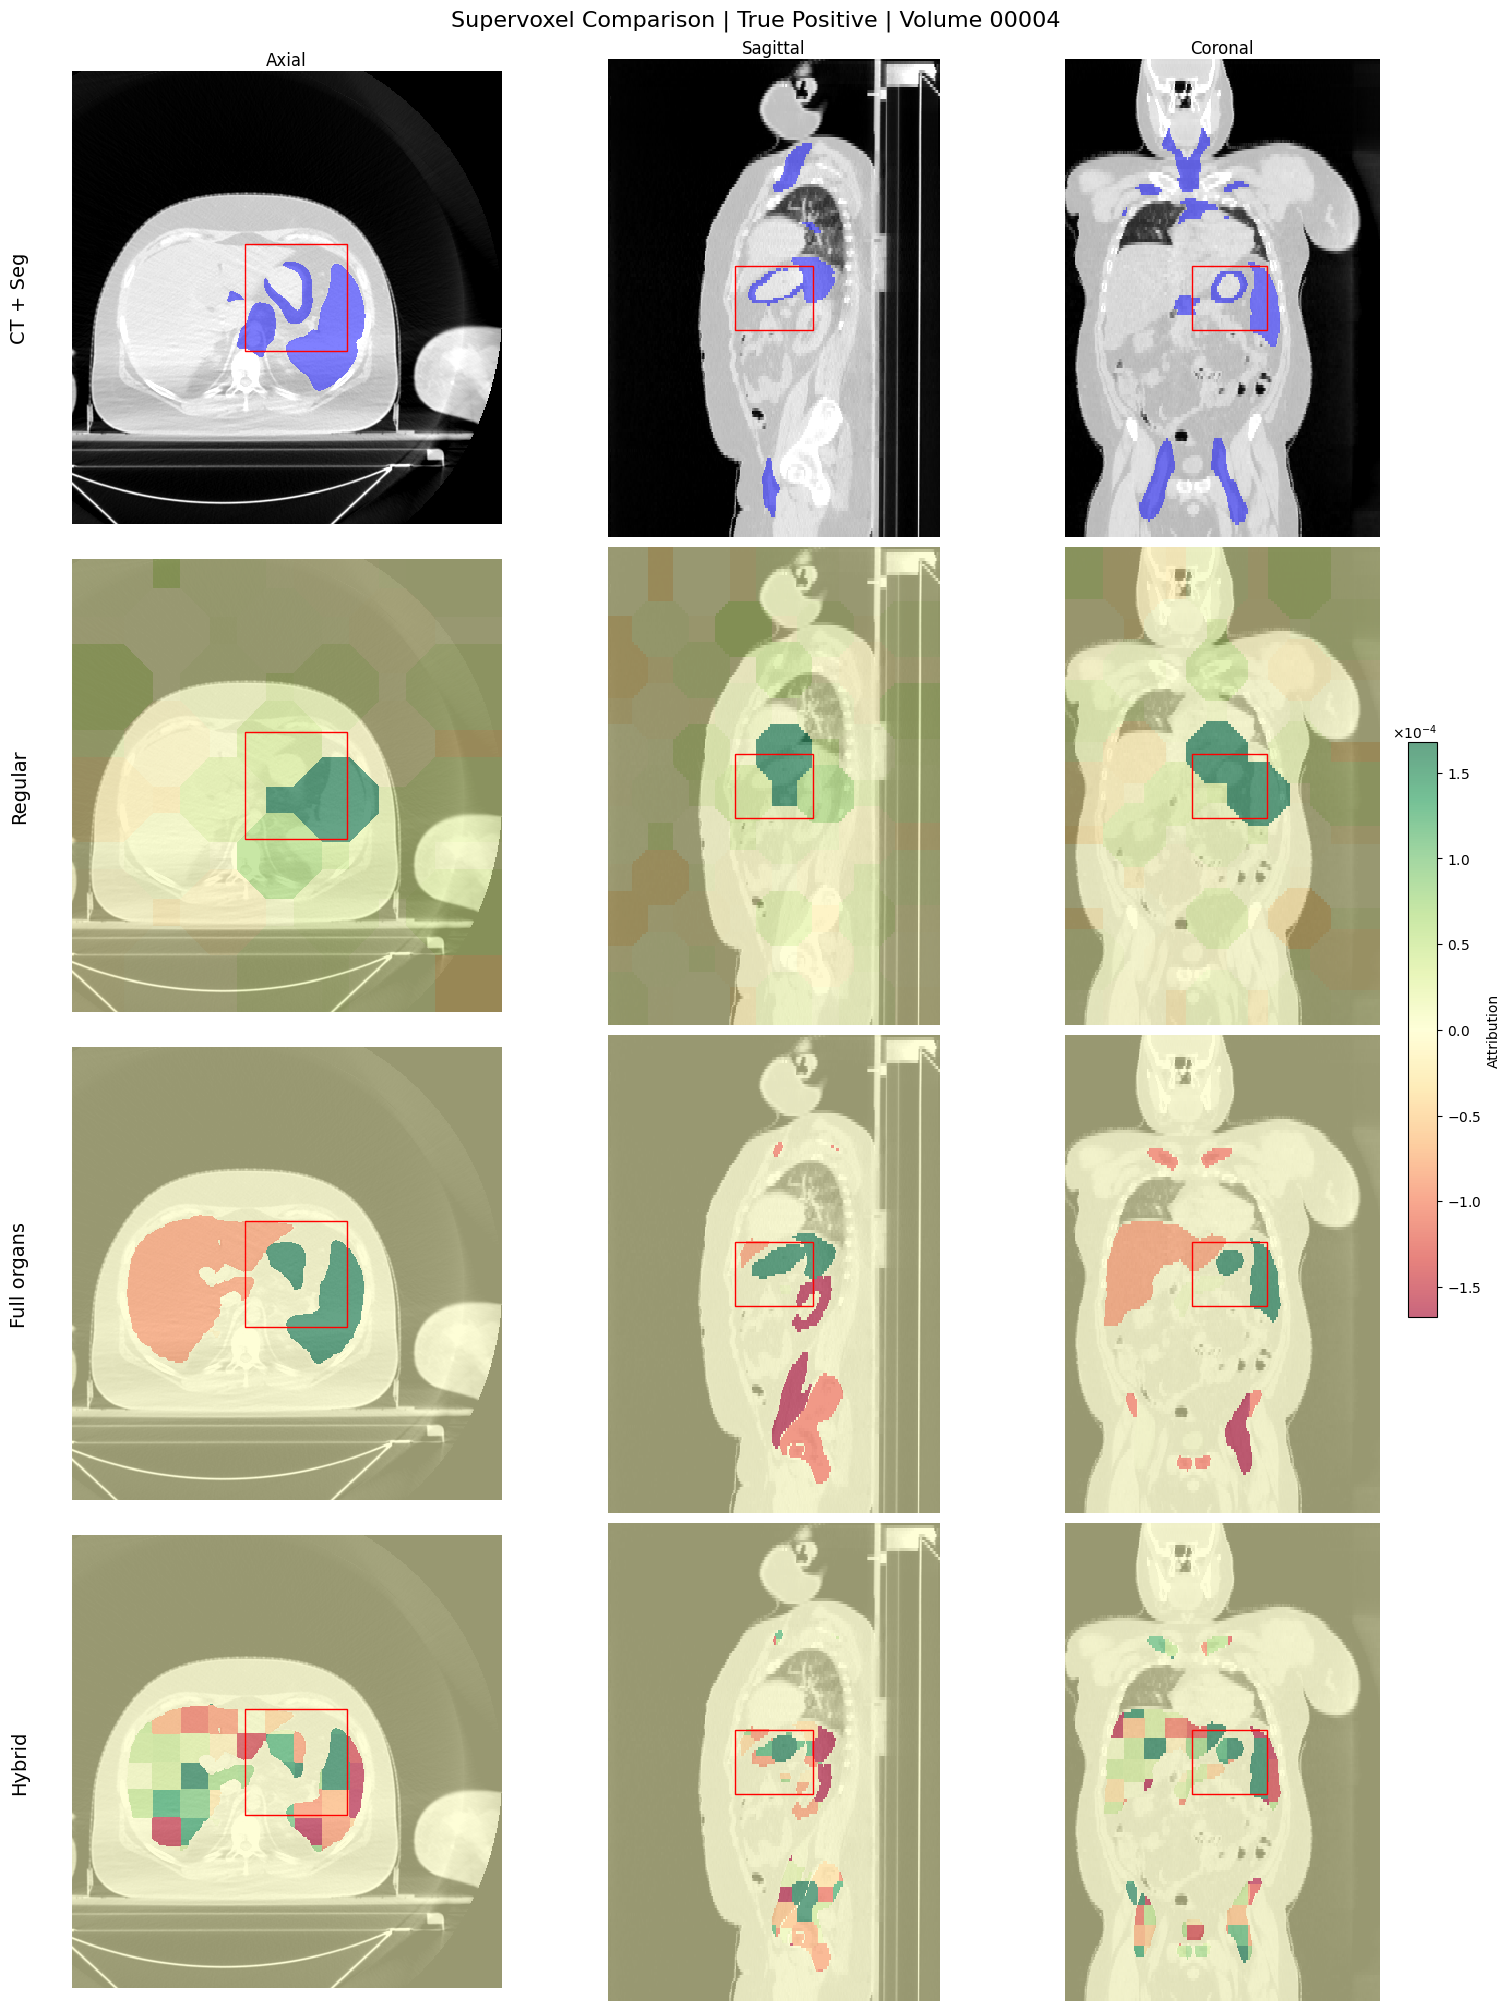

In [1045]:
# Example of a comparative plot for supervoxels
agg_func_comp = 'true_positive_aggregation'
volume_code_comp = '00004'

fig_comp_sv = plot_supervoxel_comparison(
    volume_code_comp, agg_func_comp,
    map_paths, ct_img_paths, BB_ROI_paths, segmentation_paths,
    title=f"Supervoxel Comparison | {AGGREGATION_FUNCTIONS[agg_func_comp]} | Volume {volume_code_comp}"
)

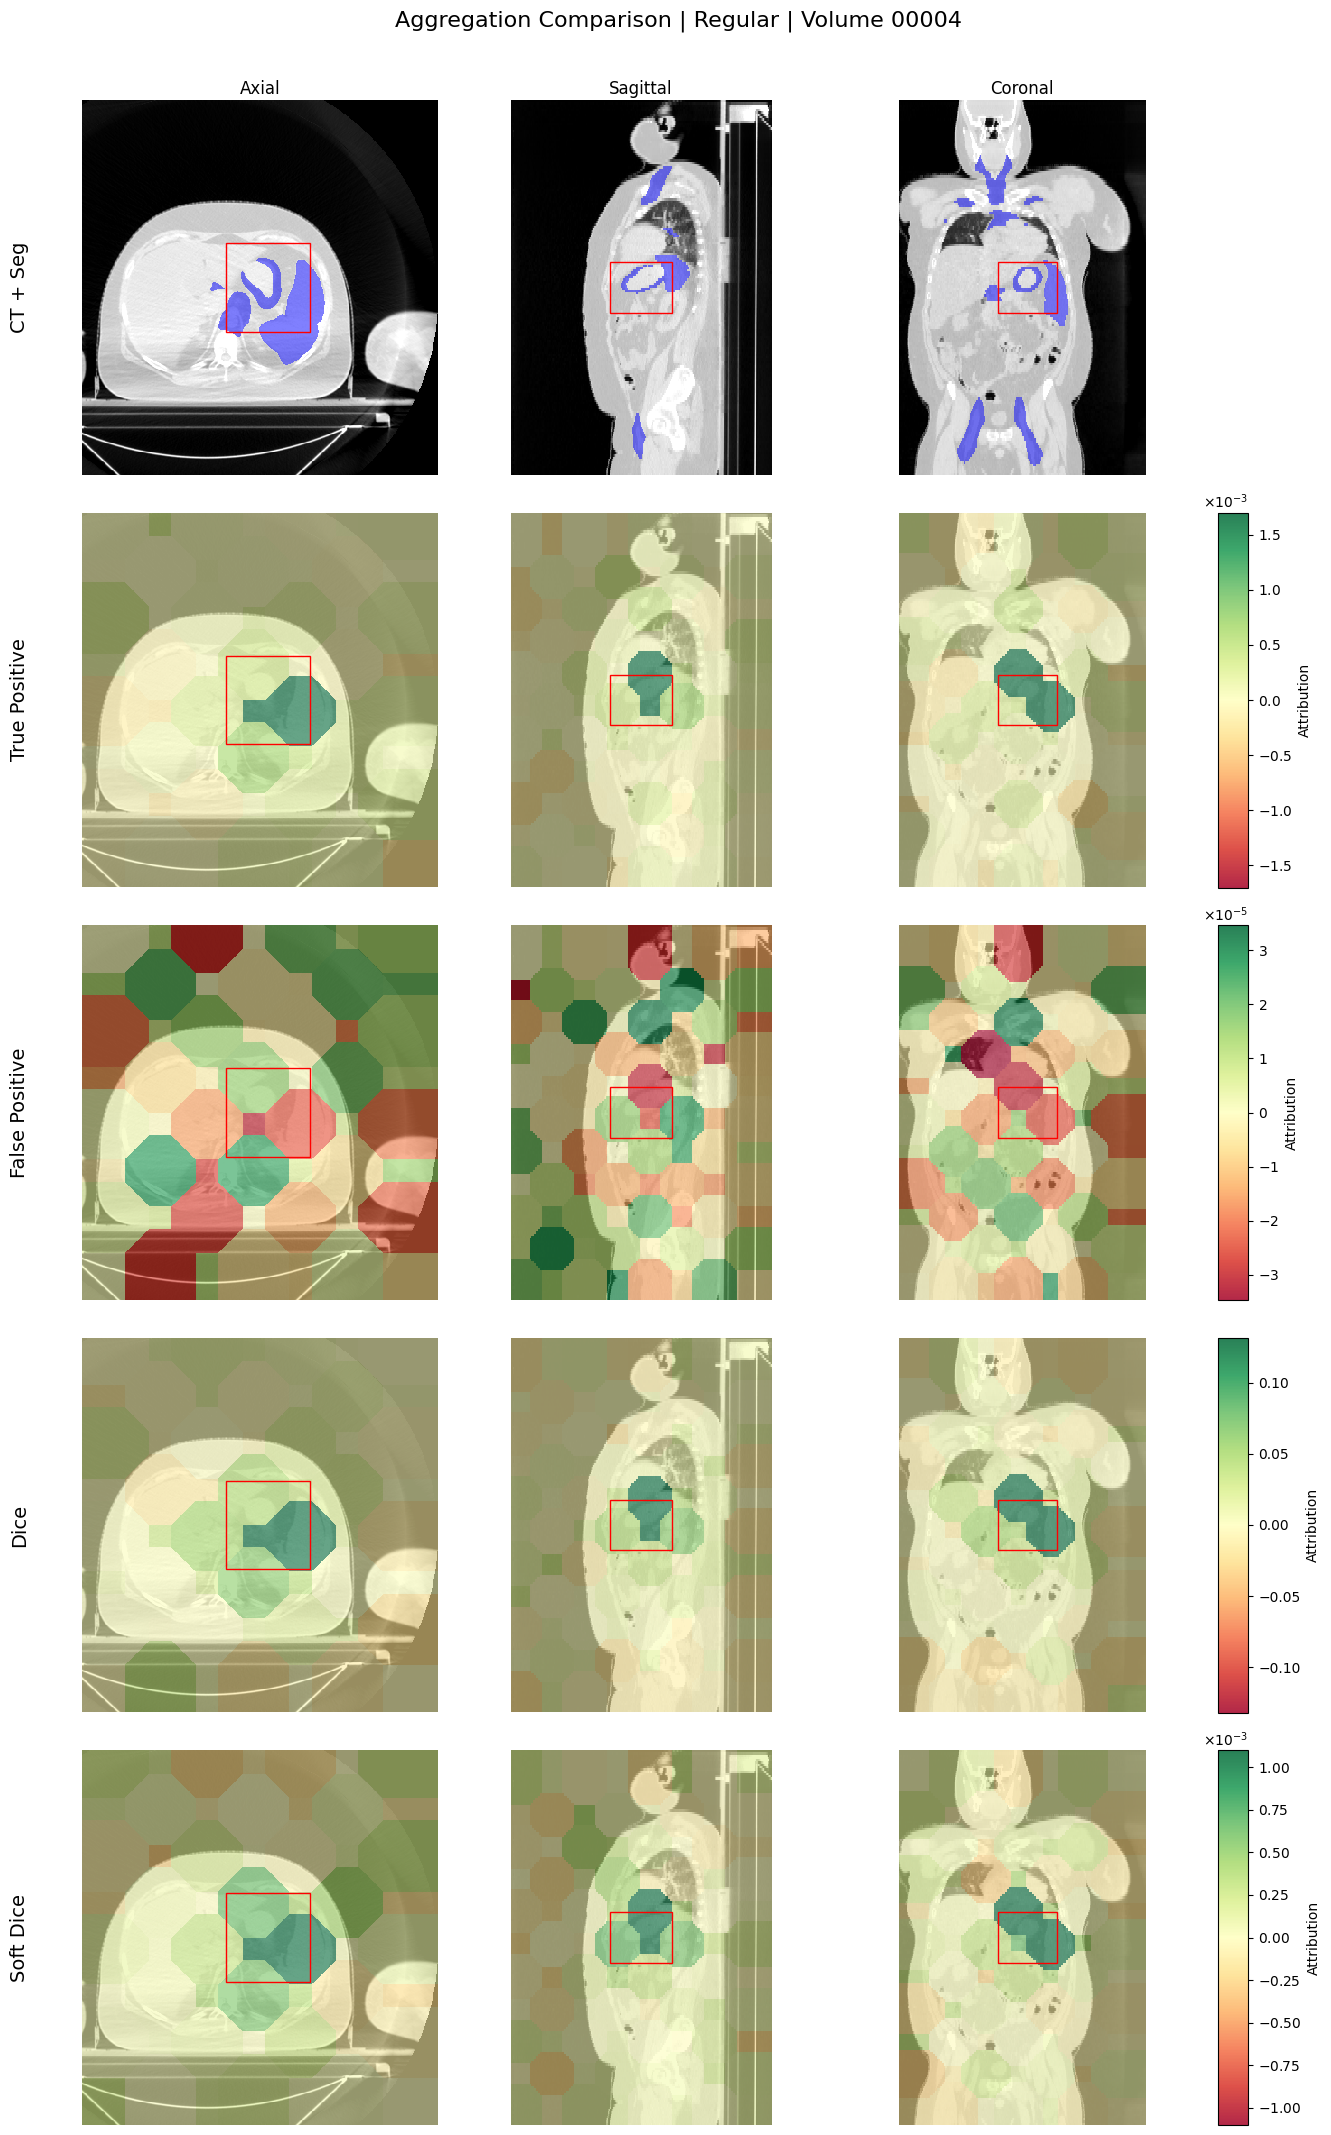

In [1044]:

# Example of a comparative plot for supervoxels
agg_func_comp = 'true_positive_aggregation'
volume_code_comp = '00004'

# Example of a comparative plot for aggregations
sv_type_comp_agg = 'FCC'
fig_comp_agg = plot_aggregation_comparison(
    volume_code_comp, sv_type_comp_agg,
    map_paths, ct_img_paths, BB_ROI_paths, segmentation_paths,
    title=f"Aggregation Comparison | {SUPERVOXEL_LABELS[sv_type_comp_agg]} | Volume {volume_code_comp}"
)
